# Imports

In [1]:
from catboost import CatBoostRegressor, EFstrType, Pool, sum_models
import h5py
import json
import joblib
import mlflow
import numpy as np
import optuna
import os
import pandas as pd
import polars as pl
import sys

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from tqdm import tqdm

/home/t3600/mambaforge/envs/boosting_mle/lib/python3.11/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,
/home/t3600/mambaforge/envs/boosting_mle/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append('../src/')
import h5_utils

In [3]:
import importlib
importlib.reload(h5_utils)

<module 'h5_utils' from '/home/t3600/0_git/Optiver-Trading-at-the-Close-retrain-monitoring/research/../src/h5_utils.py'>

# Configs

In [4]:
settings_path = '../configs/settings.json'
with open(settings_path, 'r') as f:
    config = json.load(f)

In [5]:
folder_daily_h5 = f"../{config['RAW_DATA_DIR']}/daily/"

metadata_filename = 'metadata.h5'
metadata_filepath = f"../{config['RAW_DATA_DIR']}/{metadata_filename}"

optuna_all_feat_filename = 'optuna_all_sliding.pkl'
optuna_all_feat_filenpath = f"../{config['RAW_DATA_DIR']}/{optuna_all_feat_filename}"

# Daily load trick

In [6]:
date_ids = h5_utils.load_metadata(metadata_filepath)
len(date_ids)

481

# Validation splits

In [7]:
max_train_size = 70
slide_step= max_train_size
n_samples=len(date_ids)

effective_train_size = max_train_size + gap
n_splits = (n_samples - test_size) // (effective_train_size + test_size) + 1
print(n_splits)
tscv = TimeSeriesSplit(n_splits=n_splits,
                max_train_size=max_train_size, 
                test_size=test_size, 
                gap=gap)


In [8]:
class SlidingWindowSplit:
    def __init__(self, 
                 data, 
                 train_days, 
                 #test_days, 
                 slide_step=1):
        self.data = data
        self.train_days = train_days
        self.slide_step = slide_step

    def __iter__(self):
        for i in range(self.train_days, len(self.data) + 1, self.slide_step):
            yield np.arange(i - self.train_days, i)

    def __len__(self):
        return (len(self.data) - self.train_days + 1) // self.slide_step

In [9]:
batch_ids = SlidingWindowSplit(date_ids, 
                       max_train_size, 
                       slide_step)

In [10]:
for i, train_index in enumerate(tqdm(batch_ids, 
                                    desc="Training and Validation")):
    
    print(f"Batch {i}:")
    print(f"  Train: index={train_index}")

Training and Validation: 6it [00:00, 1956.30it/s]             

Batch 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69]
Batch 1:
  Train: index=[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123
 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139]
Batch 2:
  Train: index=[140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209]
Batch 3:
  Train: index=[210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 23

# Preprocess

In [11]:
def drop_target_nan(features: np.ndarray,
                    target: np.ndarray)-> (np.ndarray, np.ndarray):
    
    mask = ~np.isnan(target)
    
    return features[mask], target[mask]

# Intermediate optuna on Catboost for feature selection

## Trial

In [12]:
def params_catboost(trial):
    
    param = {
        "loss_function" : "MAE",
        "eval_metric" : "MAE",
        "iterations" : 1000,  
        #"used_ram_limit": "14gb",
        #"learning_rate": trial.suggest_float("learning_rate", 
        #                              0.2, 0.9), # will optimize it later, catboost has good inner mechanism of choice
        "depth": trial.suggest_int("depth", 5, 10),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 
                                      3, 50),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", 
                             ["Bayesian", "Bernoulli", "MVS"])
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 
                                                 1, 20)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 
                                         0.1, 0.8)
    return param

In [13]:
def batch_learning(param, train_ids):
    '''All the data with such number of features can't fit in memory so we will update model by batches learning'''
    batches = SlidingWindowSplit(train_ids, 
                           max_train_size, 
                           slide_step)

    model_prev = None

    for batch_ind in tqdm(batches, desc="Batch training:"):
        batch_train_days = date_ids[batch_ind]
        
        # Load training data
        train_data, train_labels = h5_utils.stacked_daily_data(batch_train_days,
                                                              folder_daily_h5)

        # Preprocess
        ## Target handle NaNs
        train_data, train_labels = drop_target_nan(train_data, 
                                                   train_labels)

        batch = Pool(train_data, 
                     label=train_labels)

        model_new = CatBoostRegressor(**param, thread_count=-1, random_seed=42)
        if model_prev is None:
            model_new.fit(X=batch, verbose=1)
            model_prev = model_new
        else:
            # https://catboost.ai/en/docs/concepts/python-usages-examples#batch-training
            batch.set_baseline(model_prev.predict(batch))
            model_new.fit(X=batch, verbose=0)
            model_prev = sum_models([model_prev,model_new])
        
    return model_prev

In [14]:
def objective(trial):
    # CV
    ind_thres = 400
    train_ids = date_ids[:ind_thres]
    test_ids = date_ids[ind_thres:]
    
    param = params_catboost(trial)
    # Train
    final_model = batch_learning(param, train_ids)

    # Score
    ## Load validation data
    valid_data, valid_labels = h5_utils.stacked_daily_data(test_ids,
                                                          folder_daily_h5)
    ## NaN in target is not scored by the rules
    valid_data, valid_labels = drop_target_nan(valid_data, 
                                               valid_labels)
    valid_preds = final_model.predict(valid_data)
    ## Calculate metric
    mae = mean_absolute_error(valid_labels, valid_preds)
    return mae

## Search

In [ ]:
%%time

hours = 10

study = optuna.create_study(direction='minimize',
                pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, 
               n_trials=120,
               timeout = 60*60*hours
              )
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-07-08 23:37:52,262] A new study created in memory with name: no-name-917bc115-01a4-47c0-8982-ffff6e748138
Batch training::   0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 5.2703207	total: 560ms	remaining: 9m 19s
1:	learn: 5.1610866	total: 1.05s	remaining: 8m 43s
2:	learn: 5.0565127	total: 1.49s	remaining: 8m 15s
3:	learn: 4.9558247	total: 1.92s	remaining: 7m 59s
4:	learn: 4.8571217	total: 2.35s	remaining: 7m 47s
5:	learn: 4.7590817	total: 2.78s	remaining: 7m 40s
6:	learn: 4.6654136	total: 3.21s	remaining: 7m 35s
7:	learn: 4.5709732	total: 3.63s	remaining: 7m 29s
8:	learn: 4.4820009	total: 4.07s	remaining: 7m 27s
9:	learn: 4.3930467	total: 4.51s	remaining: 7m 26s
10:	learn: 4.3075336	total: 4.96s	remaining: 7m 26s
11:	learn: 4.2216027	total: 5.44s	remaining: 7m 27s
12:	learn: 4.1396575	total: 5.85s	remaining: 7m 24s
13:	learn: 4.0593779	total: 6.29s	remaining: 7m 23s
14:	learn: 3.9818599	total: 6.71s	remaining: 7m 20s
15:	learn: 3.9029971	total: 7.12s	remaining: 7m 17s
16:	learn: 3.8280400	total: 7.5s	remaining: 7m 13s
17:	learn: 3.7547677	total: 7.96s	remaining: 7m 14s
18:	learn: 3.6820386	total: 8.37s	remaining: 7m 12s
19:	learn: 3.6123418	to

In [ ]:
print("Best trial: score {}, params {}".format(study.best_trial.value, 
					       study.best_trial.params))

In [ ]:
len(study.trials)

## Store study (optional)

In [21]:
joblib.dump(study, optuna_all_feat_filenpath)

['.././data//optuna_all_sliding.pkl']

## Observe hyper importances

optuna.visualization.plot_param_importances(study)

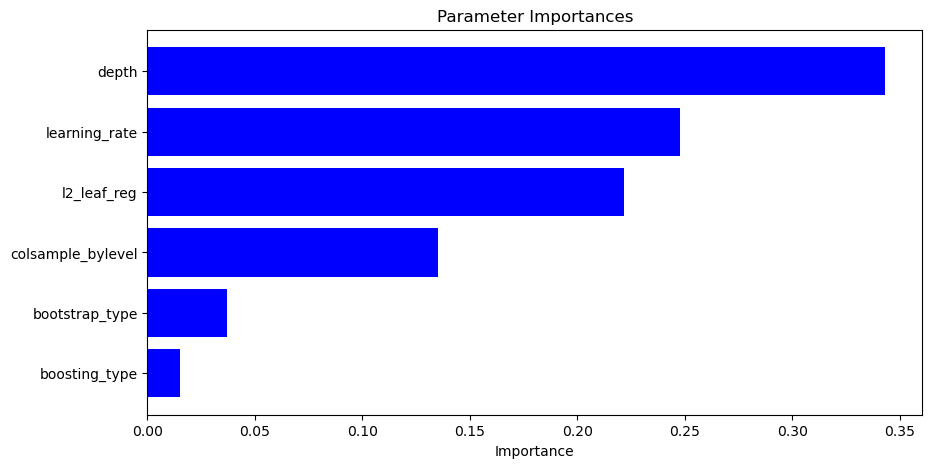

In [22]:
import matplotlib.pyplot as plt

# Get parameter importances
param_importances = optuna.importance.get_param_importances(study)

# Prepare data for visualization
names = list(param_importances.keys())
values = list(param_importances.values())

# Create bar plot
plt.figure(figsize=(10, 5))
plt.barh(names, values, color='blue')
plt.xlabel('Importance')
plt.title('Parameter Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.show()

# Selection

## Best model fit

In [26]:
%%time
best_model, _, _ = batch_learning(study.best_trial.params)

Training and Validation: 14it [39:08, 167.77s/it]                        

CPU times: user 4h 27min 48s, sys: 2min 23s, total: 4h 30min 12s
Wall time: 39min 8s


## Catboost importance approach

In [74]:
train_data.shape

(660000, 444)

In [85]:
preds = best_model.predict(train_data)
preds.shape

(660000,)

In [81]:
feature_importance_catboost2 = best_model.get_feature_importance(type=EFstrType.FeatureImportance, 
				   prettified=True, 
				   thread_count=-1, 
				   verbose=True)

In [88]:
len(best_model.feature_names_)

443

In [ ]:
best_model.feature_names_

In [96]:
set([str(nm) for nm in range(444)]).difference(set(best_model.feature_names_))

{'443'}

In [101]:
best_model.save_model('Batch_val_strange_444_443',
           format="cbm",
           export_parameters=None,
           pool=None)

In [82]:
feature_importance_catboost2.shape

(443, 2)

In [42]:
latest_train_ids = date_ids[-max_train_size:]
train_data, train_labels = h5_utils.stacked_daily_data(latest_train_ids,
                                                        folder_daily_h5)

In [60]:
date_id=date_ids[-1]
filepath=f'{folder_daily_h5}/{date_id}.h5'
with h5py.File(filepath, 'r') as f:
    # Load the target column
    target = f['data']['target'][:]

    features_group = f['data']['features']
    feature_names = list(features_group.keys())
feature_pool = Pool(train_data)

In [ ]:
feature_names

In [64]:
len(feature_names)

444

In [62]:
%%time
importance_df = pd.DataFrame({'feature_importance': feature_importance_catboost, 
                              'feature_names': feature_names}).\
                    sort_values(by=['feature_importance'], 
                                ascending=False)

ValueError: All arrays must be of the same length

In [65]:
feature_importance_catboost = best_model.get_feature_importance(feature_pool)
len(feature_importance_catboost)

443